#### Imports & Global Variables

In [1]:
import torch
import pandas as pd
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [2]:
csv_file_prefix = 'spiral'
# csv_file_prefix = 'two_gaussians'
# csv_file_prefix = 'xor'
# csv_file_prefix = 'center_surround'

batch_size = 32
hidden_size = 64
lr=0.001
num_epochs = 200
lambda_val = 0.003

<br />

# Part 1 and Part 2 and Part 4 -- PyTorch Implementation
---

Implementing and training a FFNN using PyTorch. Each task will utilize the same datasets, but will be handled differently throughout. Anything with the value p1 refers to part 1 variables and p2 refers to part 2 varaibles

*Part 1 implements Multi-class cross entropy as the cost function*

*Part 2 implements Mean-squared error as the cost function*

*Part 4 implements regularization into our model*

---

<br />

### Importing Data

We begin by utilizing PyTorch's torch.utils.data.Dataset object to create a custom dataset that could handle our custom integrations of how to handle the data. For part 1, we simply import the dataset, scale it, and convert it to a torch.tensor(). For part 2, we pass a boolean value for 'one_hot' which will convert the labels into one-hot encoded labels.

Please note that we are only scaling based on the features within the training set to allow for higher accuracy from unseen examples.

In [3]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, df, scaler, one_hot=False, transform=None):
        super().__init__()
        self.features = df.iloc[:, 1:]
        self.labels = df.iloc[:, 0]
        
        self.features = scaler.transform(self.features)

        self.transform = transform
        self.one_hot = one_hot

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.one_hot:
            one_hot_label = F.one_hot(label, num_classes=2).float() # one-hot encoding the labels so we can perform MSELoss on this... tensor([0., 1.])) is 1 and tensor([1., 0.])) is 0
            return feature, one_hot_label
        else:
            return feature, label

In [4]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')
valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

train_dataset_p1 = SimpleDataset(df=train_df, scaler=scaler, one_hot=False)
valid_dataset_p1 = SimpleDataset(df=valid_df, scaler=scaler, one_hot=False)
test_dataset_p1 = SimpleDataset(df=test_df, scaler=scaler, one_hot=False)

train_dataset_p2 = SimpleDataset(df=train_df, scaler=scaler, one_hot=True)
valid_dataset_p2 = SimpleDataset(df=valid_df, scaler=scaler, one_hot=True)
test_dataset_p2 = SimpleDataset(df=test_df, scaler=scaler, one_hot=True)

train_loader_p1 = torch.utils.data.DataLoader(train_dataset_p1, batch_size=batch_size, shuffle=True)
valid_loader_p1 = torch.utils.data.DataLoader(valid_dataset_p1, batch_size=batch_size, shuffle=False)
test_loader_p1 = torch.utils.data.DataLoader(test_dataset_p1, batch_size=batch_size, shuffle=False)

train_loader_p2 = torch.utils.data.DataLoader(train_dataset_p2, batch_size=batch_size, shuffle=True)
valid_loader_p2 = torch.utils.data.DataLoader(valid_dataset_p2, batch_size=batch_size, shuffle=False)
test_loader_p2 = torch.utils.data.DataLoader(test_dataset_p2, batch_size=batch_size, shuffle=False)

### Modeling

We define our simple feed forward network as having one hidden layer with a ReLU activation function. 

We then define our different loss functions and optimization functions below. MCE for part 1 and MSE for part 2. Adam for part 1 and SGD for part 2. 

In [5]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.f1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.f2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x

##### Initializing model / cost function / optimizer

In [6]:
input_size = train_dataset_p1.features.shape[1] 
output_size = len(set(train_dataset_p1.labels))

model_p1_no_reg = SimpleNN(input_size, hidden_size, output_size)
model_p1_with_reg = SimpleNN(input_size, hidden_size, output_size)

model_p2_no_reg = SimpleNN(input_size, hidden_size, output_size)
model_p2_with_reg = SimpleNN(input_size, hidden_size, output_size)

criterion_p1 = torch.nn.CrossEntropyLoss()
criterion_p2 = torch.nn.MSELoss()

optimizer_p1_no_reg = torch.optim.Adam(model_p1_no_reg.parameters(), lr=lr)
optimizer_p1_with_reg = torch.optim.Adam(model_p1_with_reg.parameters(), lr=lr)

optimizer_p2_no_reg = torch.optim.SGD(model_p2_no_reg.parameters(), lr=lr, momentum=0.9)
optimizer_p2_with_reg = torch.optim.SGD(model_p2_with_reg.parameters(), lr=lr, momentum=0.9)

##### Training the model

This function handles the learning aspect of our neural network, such that for each epoch, we run our features through the model to get our predictions, then obtain the loss for this iteration. After computing the loss, we are able to backpropogate through the network to learn the gradients, and then update it for the next step. 

It is important to note at this time that we also use L2-regularization when the boolean value is set to True. L2-regularization is used to increase bias and decrease variance within the model to help limit overfitting the dataset but to help generalize over new examples. 

<div style="text-align: center;">
  <img alt="L2-regularization equation" src="l2_reg.png" />
  <div><i>L2-Regularization</i></div>
</div>


In [7]:
def train(model, train_loader, valid_loader, num_epochs, criterion, optimizer, l2_regularization=False):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    train_loader: training set as a DataLoader()
    valid_loader: validation set as a DataLoader()
    num_epochs: Number of epochs
    criterion: Loss function
    optimizer: Optimization function
    l2_regularization: Boolean value representing if you want to use L2-regularization
    """
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)

            if l2_regularization:
                reg = lambda_val * torch.sum(model.f1.weight ** 2)
                loss = loss + reg

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0

        with torch.no_grad():
            for features, labels in valid_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")
        
    return train_losses, valid_losses

In [8]:
train_losses_p1_no_reg, valid_losses_p1_no_reg = train(model_p1_no_reg, train_loader_p1, valid_loader_p1, num_epochs, criterion_p1, optimizer_p1_no_reg, l2_regularization=False)
train_losses_p1_with_reg, valid_losses_p1_with_reg = train(model_p1_with_reg, train_loader_p1, valid_loader_p1, num_epochs, criterion_p1, optimizer_p1_with_reg, l2_regularization=True)

train_losses_p2_no_reg, valid_losses_p2_no_reg = train(model_p2_no_reg, train_loader_p2, valid_loader_p2, num_epochs, criterion_p2, optimizer_p2_no_reg, l2_regularization=False)
train_losses_p2_with_reg, valid_losses_p2_with_reg = train(model_p2_with_reg, train_loader_p2, valid_loader_p2, num_epochs, criterion_p2, optimizer_p2_with_reg, l2_regularization=True)

Epoch 50/200, Train Loss: 0.4092, Valid Loss: 0.4108
Epoch 100/200, Train Loss: 0.3035, Valid Loss: 0.2984
Epoch 150/200, Train Loss: 0.2064, Valid Loss: 0.1962
Epoch 200/200, Train Loss: 0.1562, Valid Loss: 0.1329
Epoch 50/200, Train Loss: 0.4440, Valid Loss: 0.4067
Epoch 100/200, Train Loss: 0.3542, Valid Loss: 0.3164
Epoch 150/200, Train Loss: 0.2847, Valid Loss: 0.2397
Epoch 200/200, Train Loss: 0.2426, Valid Loss: 0.1786
Epoch 50/200, Train Loss: 0.1421, Valid Loss: 0.1433
Epoch 100/200, Train Loss: 0.1258, Valid Loss: 0.1253
Epoch 150/200, Train Loss: 0.1156, Valid Loss: 0.1097
Epoch 200/200, Train Loss: 0.0947, Valid Loss: 0.0973
Epoch 50/200, Train Loss: 0.2104, Valid Loss: 0.1519
Epoch 100/200, Train Loss: 0.1979, Valid Loss: 0.1398
Epoch 150/200, Train Loss: 0.1858, Valid Loss: 0.1293
Epoch 200/200, Train Loss: 0.1747, Valid Loss: 0.1191


##### Testing the model (with accuracy)

In [9]:
def test_accuracy_p1(model, test_loader):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    test_loader: test set as a DataLoader()
    """
    
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)            

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test    
    return test_accuracy

def test_accuracy_p2(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, one_hot_labels in test_loader:
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)
                
                labels = torch.argmax(one_hot_labels, dim=1)

                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test    
    return test_accuracy

In [10]:
test_accuracy_p1 = test_accuracy_p1(model_p1_no_reg, test_loader_p1)
test_accuracy_p2 = test_accuracy_p2(model_p2_no_reg, test_loader_p2)

print("Test Accuracy (Problem 1): ", test_accuracy_p1)
print("Test Accuracy (Problem 2): ", test_accuracy_p2)

Test Accuracy (Problem 1):  100.0
Test Accuracy (Problem 2):  87.0



### Plotting Loss Curves and Decision Boundaries

*Please note that ChatGPT was utilized for the plots. We originally made our own version based on the decision boundary code you left for us in example.ipynb. But decided that rather than 4 individual plots each time, that it may be cleaner if expressed in a 2x2 fig, ax plot. So we did have ChatGPT quickly create these plots for us for the purpose of making the data easier to understand. We only chose to do this because we thought that the plots were not the focus of the homework, but were just the way to show the viewer what our own code actually learned.*

In [11]:
def plot_loss_curves_2x2_fixed(train_losses_p1_no_reg, valid_losses_p1_no_reg, 
                               train_losses_p1_with_reg, valid_losses_p1_with_reg, 
                               train_losses_p2_no_reg, valid_losses_p2_no_reg, 
                               train_losses_p2_with_reg, valid_losses_p2_with_reg):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    # Corrected placement order: 
    # Top row (P1), Bottom row (P2)
    # Left column (No Regularization), Right column (With Regularization)
    train_losses = [
        train_losses_p1_no_reg, train_losses_p1_with_reg, 
        train_losses_p2_no_reg, train_losses_p2_with_reg
    ]
    valid_losses = [
        valid_losses_p1_no_reg, valid_losses_p1_with_reg, 
        valid_losses_p2_no_reg, valid_losses_p2_with_reg
    ]
    titles = [
        "No regularization / Dataset: P1 / Loss: MCE",
        "With regularization / Dataset: P1 / Loss: MCE",
        "No regularization / Dataset: P2 / Loss: MSE",
        "With regularization / Dataset: P2 / Loss: MSE"
    ]

    for i, ax in enumerate(axes):
        ax.plot(list(range(1, num_epochs + 1)), train_losses[i], label='train loss')
        ax.plot(list(range(1, num_epochs + 1)), valid_losses[i], label='valid loss')
        ax.set_title(f'Loss Curves ({titles[i]})')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_decision_boundaries_2x2_fixed(model_p1_no_reg, model_p1_with_reg, 
                                       model_p2_no_reg, model_p2_with_reg, 
                                       train_loader_p1, train_loader_p2, 
                                       csv_file_prefix, hidden_size):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    # Corrected placement order:
    # Top row (P1), Bottom row (P2)
    # Left column (No Regularization), Right column (With Regularization)
    models = [model_p1_no_reg, model_p1_with_reg, model_p2_no_reg, model_p2_with_reg]
    loaders = [train_loader_p1, train_loader_p1, train_loader_p2, train_loader_p2]
    titles = [
        f"-Unregularized- Dataset: P1 / Nodes: {hidden_size} / Loss: MCE",
        f"-Regularized- Dataset: P1 / Nodes: {hidden_size} / Loss: MCE",
        f"-Unregularized- Dataset: P2 / Nodes: {hidden_size} / Loss: MSE",
        f"-Regularized- Dataset: P2 / Nodes: {hidden_size} / Loss: MSE"
    ]
    one_hot_flags = [False, False, True, True]  # P2 datasets require one-hot decoding

    for i, ax in enumerate(axes):
        model = models[i]
        train_loader = loaders[i]
        title = titles[i]
        one_hot = one_hot_flags[i]

        y_min, y_max = train_loader.dataset.features[:, 1].min(), train_loader.dataset.features[:, 1].max()
        x_min, x_max = train_loader.dataset.features[:, 0].min(), train_loader.dataset.features[:, 0].max()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

        grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
        with torch.no_grad():
            Z = model(grid_points) 
            Z = Z.argmax(dim=1).numpy()

        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

        for inputs, label in train_loader:
            inputs = inputs.numpy()
            labels = label.numpy()
            if one_hot:
                labels = label.argmax(dim=1).numpy()
            ax.scatter(inputs[:, 0], inputs[:, 1], c=labels, edgecolor='k', cmap='coolwarm', marker='o')

        ax.set_title(title)
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")

    plt.tight_layout()
    plt.show()

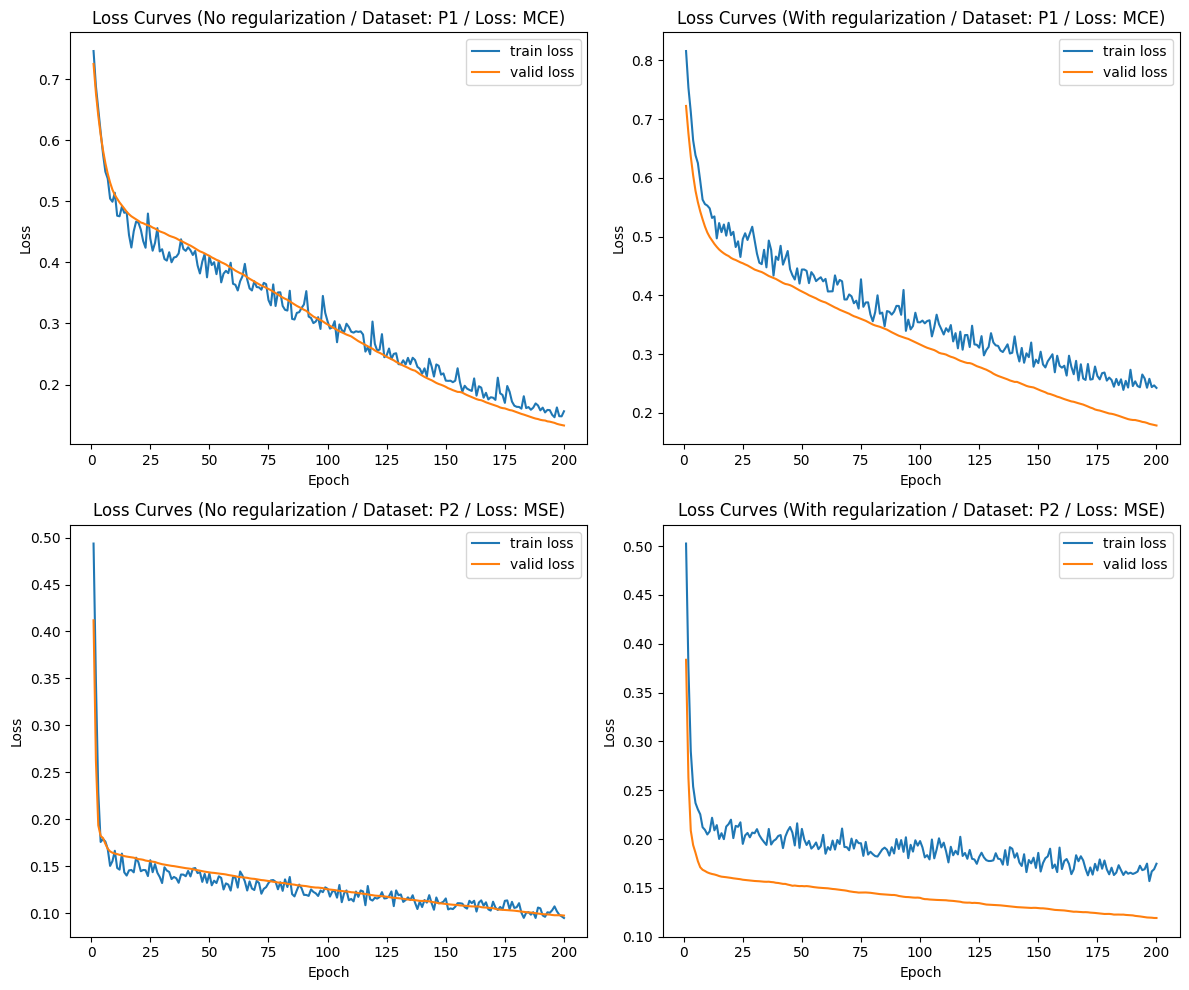

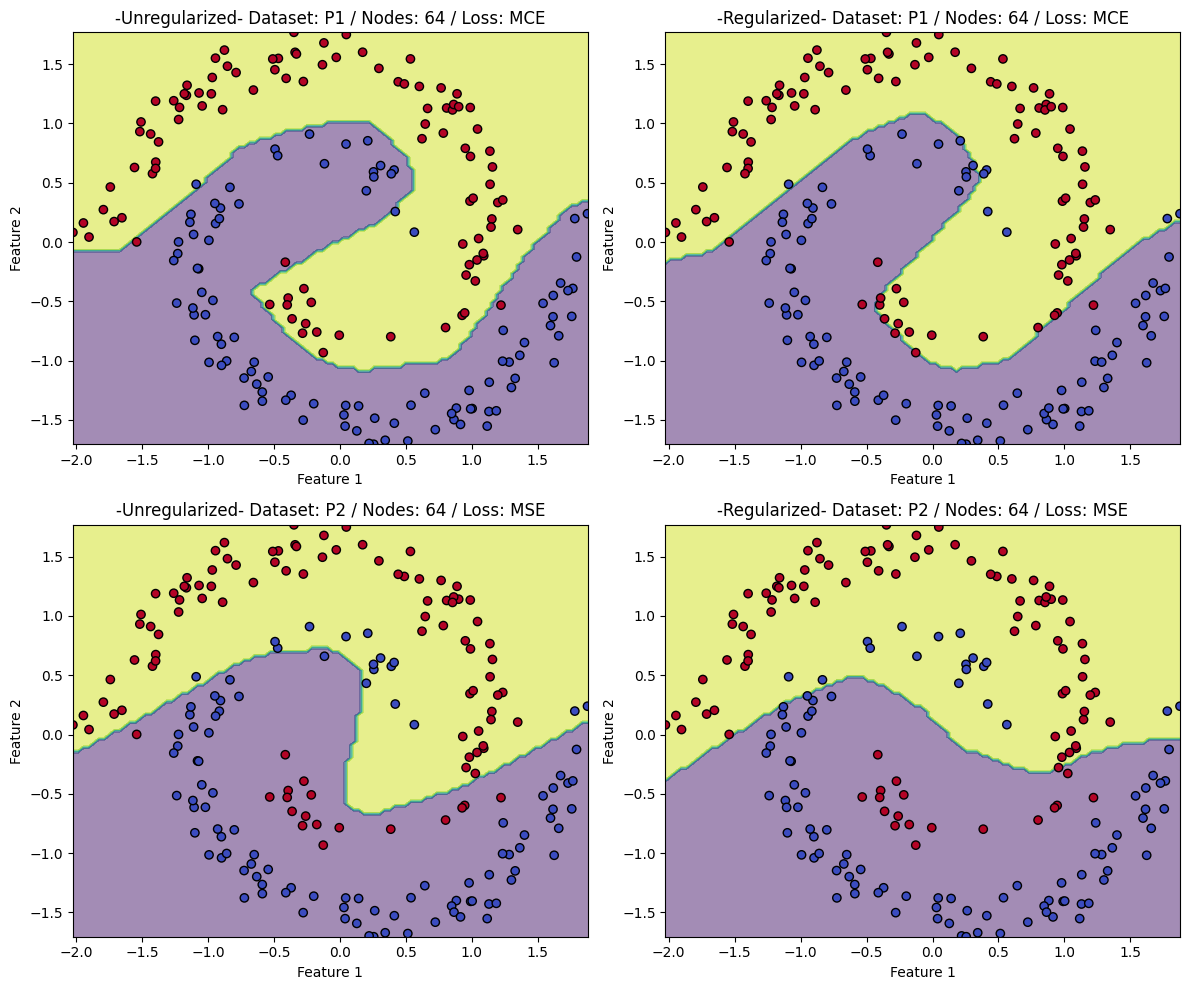

In [12]:
# Loss curves
plot_loss_curves_2x2_fixed(
    train_losses_p1_no_reg, valid_losses_p1_no_reg,
    train_losses_p1_with_reg, valid_losses_p1_with_reg,
    train_losses_p2_no_reg, valid_losses_p2_no_reg,
    train_losses_p2_with_reg, valid_losses_p2_with_reg
)


# Decision Boudaries
plot_decision_boundaries_2x2_fixed(
    model_p1_no_reg, model_p1_with_reg,
    model_p2_no_reg, model_p2_with_reg,
    train_loader_p1, train_loader_p2,
    csv_file_prefix, hidden_size
)

<br />
<br />
<br />
<br />
<br />

# Part 3 -- Neural Network From Scratch

In [13]:
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def mcce(softmax_logits, labels):
    return - np.sum(labels * np.log(softmax_logits))

def sigmoid(unactivated):
    return 1 / (1 + np.exp(-unactivated))

def sigmoid_derivative(activated):
    return sigmoid(activated) * (1 - sigmoid(activated))

def relu(unactivated):
    return np.maximum(0, unactivated)

def relu_derivative(activated):
    return (activated > 0).astype(float)

In [14]:
np.ones((2, 10))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [15]:
np.ones((32, 2))


array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [16]:
((np.ones((32, 2)) * 1) @ (np.ones((2, 32)) * 2)).shape


(32, 32)

In [17]:
((np.ones((32, 2)) * 1) @ (np.ones((2, 32)) * 2)) + np.ones(32)


array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])

In [18]:
arr = [[-2, 3, 2]]
sm = softmax(arr)
sm, sum(sm[0]), mcce(sm, [[0, 0, 1]]), mcce(sm, [[1, 0, 0]]), mcce(sm, [[0, 1, 0]])

(array([[0.00490169, 0.72747516, 0.26762315]]),
 1.0,
 1.318175429247454,
 5.318175429247454,
 0.31817542924745396)

In [19]:
class model:
    def __init__(self, input_size=2, hidden_size=64, output_size=2):
        shape_i_h = (input_size, hidden_size)
        shape_h_o = (hidden_size, output_size)

        self.w_i_h = np.random.normal(loc=0.0, scale=1.0, size=shape_i_h) # randomly sample unique weights from a gaussian dist with mean 0 and std 1
        self.w_h_o = np.random.normal(loc=0.0, scale=1.0, size=shape_h_o) # randomly sample unique weights from a gaussian dist with mean 0 and std 1

        self.b_i_h = np.zeros(shape=(1, hidden_size)) # set biases to zero
        self.b_h_o = np.zeros(shape=(1, output_size)) # set biases to zero

        self.num_params = input_size * hidden_size + hidden_size * output_size + hidden_size + output_size

    def forward(self, features, train=False):
        forward_results = {}

        forward_results['features'] = features
        i_h = features @ self.w_i_h
        forward_results['i_h'] = i_h
        i_h_b = i_h + self.b_i_h
        forward_results['i_h_b'] = i_h_b
        a_i_h_b = relu(i_h_b)
        forward_results['a_i_h_b'] = a_i_h_b        

        h_o = a_i_h_b @ self.w_h_o
        forward_results['h_o'] = h_o        
        h_o_b = h_o + self.b_h_o
        forward_results['h_o_b'] = h_o_b
        a_h_o_b = softmax(h_o_b)
        forward_results['a_h_o_b'] = a_h_o_b

        if train:
            return a_h_o_b, forward_results
        return a_h_o_b

    def backward(self, forward_results, labels):
        gradients = {}
        
        probs = forward_results['a_h_o_b']
        
        dL_dh_o_b = probs - labels
        
        a_i_h_b = forward_results['a_i_h_b']
        gradients['w_h_o'] = a_i_h_b.T @ dL_dh_o_b
        gradients['b_h_o'] = np.sum(dL_dh_o_b, axis=0, keepdims=True)

        dL_da_i_h_b = dL_dh_o_b @ self.w_h_o.T 
        dL_di_h_b = dL_da_i_h_b * relu_derivative(forward_results['a_i_h_b'])

        gradients['w_i_h'] = forward_results['features'].T @ dL_di_h_b 
        gradients['b_i_h'] = np.sum(dL_di_h_b, axis=0, keepdims=True)

        return gradients
        
    def update_weights(self, gradients, learning_rate):
        self.w_h_o -= (learning_rate * gradients['w_h_o'])
        self.b_h_o -= (learning_rate * gradients['b_h_o'])
        self.w_i_h -= (learning_rate * gradients['w_i_h'])
        self.b_i_h -= (learning_rate * gradients['b_i_h'])

    def train(self, features, labels, valid_features, valid_labels, num_epochs, learning_rate):
        train_loss = []
        valid_loss = []
        
        for i in range(num_epochs):
            probs, forward_results = self.forward(features, train=True)
            
            gradients = self.backward(forward_results, labels)
            # for k, v in gradients.items():
            #     print(f'{k}: {v.shape}')
            
            self.update_weights(gradients, learning_rate)
            
            loss = mcce(forward_results['a_h_o_b'], labels)
            train_loss.append(loss)

            probs, forward_results = self.forward(valid_features, train=True)
                                    
            loss = mcce(forward_results['a_h_o_b'], valid_labels)
            valid_loss.append(loss)
        
        return train_loss, valid_loss
    
    def predict(self, features):
        y_predicted = self.forward(features)
        predicted_labels = np.array([np.argmax(y_p) for y_p in y_predicted])
        return predicted_labels


In [20]:
i = np.ones((1, 2))
i_multiple = np.ones((16, 2))

In [21]:
m = model()
m.forward(i), m.forward(i_multiple).shape

(array([[5.51802409e-14, 1.00000000e+00]]), (16, 2))

In [22]:
_, results = m.forward(i_multiple, True)
m.backward(results, np.ones((16, 2)))

{'w_h_o': array([[-2.09478396e+01, -1.15818734e-12],
        [-1.94876116e+01, -1.07745264e-12],
        [-9.21085466e+00, -5.09259926e-13],
        [-4.04250041e+01, -2.23506236e-12],
        [-2.03972241e+00, -1.12774430e-13],
        [ 0.00000000e+00,  0.00000000e+00],
        [-3.10497347e+01, -1.71671209e-12],
        [-3.68875407e+01, -2.03947917e-12],
        [ 0.00000000e+00,  0.00000000e+00],
        [-3.37152592e+01, -1.86408656e-12],
        [ 0.00000000e+00,  0.00000000e+00],
        [-5.69876401e+00, -3.15079571e-13],
        [-5.26414944e+00, -2.91050120e-13],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [-1.07417585e+01, -5.93902229e-13],
        [-9.11791951e+00, -5.04121624e-13],
        [ 0.00000000e+00,  0.00000000e+00],
        [-1.05144827e+01, -5.81336353e-13],
        [ 0.00000000e+00,  0.00000000e+00],
        [-1.57268852e+0

In [23]:
def z_score(df, scaler):
    features = df.iloc[:, 1:]
    labels = df.iloc[:, 0]

    features = scaler.transform(features)
    num_labels = len(np.unique(labels))
    labels = np.array([[1 if int(label) == i else 0 for i in range(num_labels)] for label in labels])
    return features, labels

In [24]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_features, train_labels = z_score(train_df, scaler)
valid_features, valid_labels = z_score(valid_df, scaler)
test_features, test_labels = z_score(test_df, scaler)


In [25]:
train_features


array([[-2.77791563e-01,  1.35395746e+00],
       [ 1.67274789e+00, -3.45859511e-01],
       [-4.93735018e-01,  1.45352085e+00],
       [-4.67327018e-01,  1.54910559e+00],
       [ 1.39855047e+00, -8.47922756e-01],
       [ 1.28268434e+00, -1.01267747e+00],
       [-4.00262601e-01, -5.30592602e-01],
       [-3.30490868e-01,  1.58647076e+00],
       [-3.63258727e-01, -6.47713114e-01],
       [-1.39811858e+00,  1.18857006e+00],
       [ 9.78624757e-01, -1.25146899e+00],
       [-1.27022071e-01, -9.32982958e-01],
       [-3.93097549e-01, -4.72506863e-01],
       [-1.99151036e-01, -1.36354015e+00],
       [-1.42185427e+00,  5.76747404e-01],
       [ 9.87598576e-01,  1.13456030e+00],
       [ 8.99844197e-01,  1.14164156e+00],
       [-1.65346982e+00,  2.04701797e-01],
       [-1.22433690e+00,  1.13403462e-03],
       [ 1.27278916e-01, -1.59315768e+00],
       [ 8.82153287e-01, -1.40075931e+00],
       [ 5.38300823e-01, -1.37647378e+00],
       [-8.99353962e-01, -8.61963591e-01],
       [ 8.

In [26]:
train_labels


array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1,

In [27]:
m = model(input_size=2, hidden_size=9, output_size=2)

num_epochs = 1000
learning_rate = 0.001
train_loss, valid_loss = m.train(train_features, train_labels, valid_features, valid_labels, num_epochs, learning_rate)

In [28]:
test_results = m.predict(test_features)
np.sum([1 for i, t_l in enumerate(test_labels) if np.argmax(t_l) == test_results[i]]) / len(test_labels)

1.0

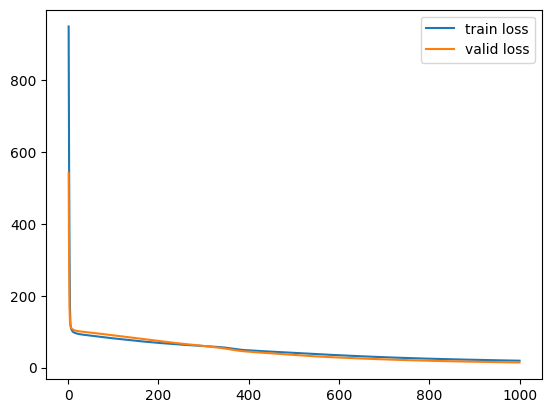

In [29]:
plt.plot(range(1, num_epochs + 1), train_loss, label='train loss')
plt.plot(range(1, num_epochs + 1), valid_loss, label='valid loss')
plt.legend()

plt.show()

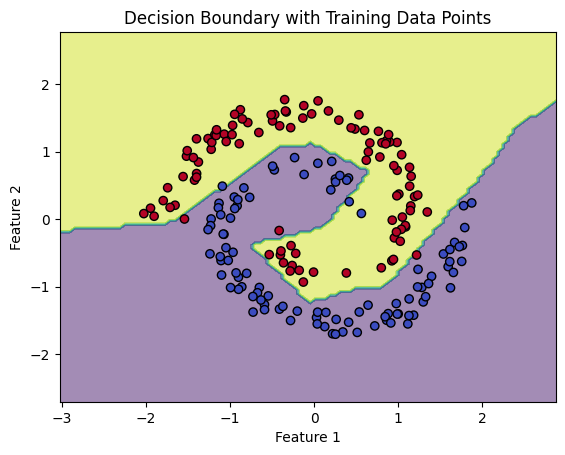

In [30]:
x_min, x_max = train_features[:, 0].min() - 1, train_features[:, 0].max() + 1
y_min, y_max = train_features[:, 1].min() - 1, train_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict labels for all points in the meshgrid
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = m.predict(grid_points)
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

# Scatter plot of training points
plt.scatter(train_features[:, 0], train_features[:, 1], c=np.array([np.argmax(l) for l in train_labels]), edgecolor='k', cmap='coolwarm', marker='o')

plt.title("Decision Boundary with Training Data Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [31]:
m.w_i_h

array([[ 1.36430662, -0.98731786,  2.49409926,  0.71990809, -0.92483792,
         0.16295075, -3.33780491, -0.9405208 , -1.18259006],
       [-1.1738028 ,  2.74001333, -1.84228064, -0.58184011, -2.50860074,
         0.45061733, -1.52126674,  0.86108538,  0.49471552]])

In [32]:
m.b_i_h

array([[ 1.37270373, -1.25140594, -2.11005699,  0.69610902, -1.65468908,
        -0.80032951,  0.21140829, -0.8440343 ,  1.33165675]])